In [165]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec 

from astropy.io import fits
from astropy import units as u
from astropy import modeling
from astropy.table import Table

from astropy import modeling
from astropy import constants as cnst

# TO DO LIST:
## do centroid method across whole spec-bins
## test cross-correlation with a lag, and then alpha
## do Flux calibrations

## General Procedure
#### Overscan/Bias
#### Small Scale Flat
#### Combine exposures
#### Sky subtration
#### Extract Target Spectrum & collapse to 1D

How to use this pipeline for Dispersion Solution:

1. define ALL files to be used in reduction (see example for list)
2. set specset = dispersion fcn to use in guess_plot
3. use dispersion outputted graphs to estimate wl & pixel matches
4. use guess_plot to get linelist matches to refine pixel estimates 
5. collect ~5 of these in lists
6. use goodness_of_matches to populate more matches based on inital guesses & plot residuals
7. if satisfied, set ds = goodness_of_matches; this is the dispersion solution now

How to extract 1D Spectrum of Target---for each side!
1. define a targetID & skyaps
2. run sky_subtract and refine skyaps based on first graph produced
3. if satisfied set flux, unc = sky_subtract; this is the target's 1D flux spectrum for that side

How to combine red & blue sides to get one complete target spectrum
1. use combine_red_blue fcn BUT note i havent done flux calibrations yet! (this will come before running fcn)

In [166]:
def guess_plot(pxguess, wlguess, specset, pxwindw=300, wlwindow=400): 
    fig, (ax1, ax2) = plt.subplots(1,2)

    ds, wlatlas, specatlas, linelist = specset 
    
    #use these graphs to refine matching of arcs to atlas
    
    #first graph 
    plt.axes(ax1)
    ds.plot_spec() #1D spectrum of dispersion solution or is this the arc..waiting on eriks answer
    plt.axvline(pxguess, color='k', ls=':') #plot a vertical line where think peak pixel is in emission lines
    plt.xlim(pxguess-pxwindw/2, pxguess+pxwindw/2)
    #plt.ylim(0, np.max(ds.spec1d[plt.xlim()[0] : plt.xlim()[1]])*1.05)
    plt.title('DS 1D Spectrum')

    
    #second graph
    plt.axes(ax2)
    plt.plot(wlatlas, specatlas) #plots what atlas spectrum looks like
    plt.title('Atlas 1D Spectrum')
    plt.axvline(wlguess, color='k', ls=':')
    plt.xlim(wlguess-wlwindow/2, wlguess+wlwindow/2)
    
    #defs the min & max wavelength peaks to use to scale in next lines
    minpx = np.argmin(np.abs(wlatlas-(wlguess-wlwindow/2)))
    maxpx = np.argmin(np.abs(wlatlas-(wlguess+wlwindow/2)))
    
  
    
    #sets wavelength scales based on graph size-ish
    plt.ylim(0, specatlas[minpx:maxpx].max()*1.05)
    guess = reduce_dblspec.nearest_in_line_list(wlguess, linelist)
    plt.axvline(guess[0], color='r', ls=':') #for 1st wavelength to linelist match draw red vertical line
    
    return guess #outputs wavelength guesses based on atlas spec known linelists

In [167]:
def dispersion(all_side_files,atlasfiles,arcfiles,linelist,flatid):
    #Overscan the flats
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #flatid is name flats saved as ex: 'DomeFlat'
    
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)

    header = atlasfiles[0].header    
    specnoao = atlasfiles[0].data
    wlnoao = header['CRVAL1'] + header['CD1_1']*(np.arange(len(specnoao)) - header['CRPIX1'] + 1) #+1 is for 0-based

    #creating dispersion solution
    ds = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl), (320, 360))
    
    #print(header['IRAFNAME']) 
    
    #outputs graphs of atlas
    plt.figure(figsize=(20,5))
    plt.plot(wlnoao, specnoao)
    plt.title('Atlas 1D Spectrum-wavelengths')
    plt.xlabel('wavelengths')
    #atlas plot axis range limit choices
    if header['IRAFNAME']=='henear.spec': #redside
        #print('red') #tested & worked
        print('used atlas plot limits for Red side')
        plt.xlim(5000,10000)
    elif header['IRAFNAME']=='FeAr.spec': #blueside
        #print('blue') #tested & worked
        print('used atlas plot limits for Blue side')
        plt.xlim(3000,5500)
        plt.ylim(0,5e5) #how to make this more flexible?
    else: #not sure why this prints for redside b/c its still choosing the correct xrange&blue does too
        print("can't determine camera side for atlas plot limits based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
    #outputting arc graph so can guess lines
    plt.figure(figsize=(20,5))
    plt.xlabel('pixels')
    plt.title('Arc Lamp 1D Spectrum-pixels')
    ds.plot_spec()
    #extra condition just for blue side orientation b/c of camera inversion to make comparison to atlas easier
    if header['IRAFNAME']=='FeAr.spec': #blueside
        plt.xlim([2800,0]) #for arc
    
    specset = (ds, wlnoao, specnoao,linelist)
    return (specset) #returns input for guess_plot along with graphs to make pixel & wl guesses

In [168]:
def goodness_of_matches(arcfiles, guesses,all_side_files, atlasfiles,linelist,flatid):
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #flatid is how flat files were named, ex: 'DomeFlat'
    #outputs = []
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)
    header = atlasfiles[0].header    
    
    arcimg = reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl)
    
    #print(header['IRAFNAME'])
    if header['IRAFNAME']=='henear.spec': #redside
        print('chose ds for redside')
        ds = reduce_dblspec.DispersionSolution(arcimg, (320, 360), poly_order=3)
        #print('ds for red')
    elif header['IRAFNAME']=='FeAr.spec': #blueside
        print('chose ds for blueside')
        ds = reduce_dblspec.DispersionSolution(arcimg, (205, 260), poly_order=3)
    else:#for some reason this prints AS WELL AS prints indicating red side choosen for red side only, blue works fine
        print("camera side for ds not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")


    
    outputs = []
    for i in guesses:
            list_a = ds.guess_line_loc(i[0], i[1]) #guesses(pixel, wl)
            outputs.append(list_a) #why am i collecting these? where are they used?
            
    #print(header['IRAFNAME'])
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('chose guesses for blueside')
        ds.guess_from_line_list(linelist,minpeakratio=5, continuous_fit=True, sigmaclip=True, max_wl=5400)    
    elif header['IRAFNAME']=='henear.spec': #redside
        print('chose guesses for redside')
        ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)
    else:
        print("camera side for guesses not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")
        #ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=3000)
    



    #1st graph-residuals
    plt.figure(figsize=(20,5))
    residuals = ds.plot_solution(True)  
    #2nd graph-populated matches, px to wl;want linear 
    plt.figure(figsize=(20,5))
    ds.plot_spec_wl()
    
    return (ds) 

In [169]:
#skyaps=[(lower bound pixel location in (x,y), upper bound pixel location in (x,y))]
#play with vmax & vmin to get better contrast
def sky_subtract(targetID,skyaps,ds,all_side_files,atlasfiles,all_side_files_target,flatid,specaps,vmax,vmin,model):
    #need these again -flats/overscan
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    nfl = reduce_dblspec.create_normalized_flat(flats)
    
    header = atlasfiles[0].header    


    
    #locating all files w/ the target & flat/overscan subt
    specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files)]
    
    
    print(len(specs),'target files located')


    
    
    #stacking all that data for specific target-help increase s/n 
    comb = reduce_dblspec.combine_imgs(specs)
    
    
    
    
#REDO A TEST HERE TO REPLACE VMIN/VMAX WITH LOG = TRUE AND SEE IF THAT HELPS 11/9/15


    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(20,10)) #setting up fig size
    #subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0))
    value = model[1]
    
    if model== 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0))
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value))
    elif model == ('legendre',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Legendre1D(value))
    elif model == ('hermite',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Hermite1D(value))
    elif model == ('cheb',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Chebyshev1D(value))
    else: 
        print ("Model type or polynomial degree not recognized")
    



    
    
    
    plt.subplot(211)
    plt.title('2D spec - Verify skyaps for correct target extraction')
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 2D spec for blueside')
        subimg.show_image(transpose=True,vmax=vmax,vmin=vmin)
        plt.figure(figsize=(20,10)) #setting up fig size
        ##subimg.show_image(transpose=True,vmax=40,vmin=-10)
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 2D spec for redside')
        subimg.show_image(transpose=False,vmax=vmax,vmin=vmin)#vmax=40,vmin=-10) 
        plt.figure(figsize=(20,10)) #setting up fig size
    else:
        print("camera side for 2D spec not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
    
    #setting up 1D extraction of target
    #this doesnt work well so try to add in an input for extraction aka 'specaps'
    
    #ideally take out and make into a new function - taking all out for now to redesign
    #setting up extraction range based on sky apps not sure if these is good to do b/c depends on extension of gal size
    ##begin = (skyaps[0][0] + 60)
    ##print ('this is beginning value of target spec extraction:',begin)
    ##end = (skyaps[1][0] - 30)
    ##print('this is end value of target spec extraction:',end)
    ##flux, unc = subimg.extract_spectrum((begin,end))
    
    flux, unc = subimg.extract_spectrum(specaps) #edited here
    
    
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])

    
    return (flux, unc, comb)



In [170]:
#this returns the complete 1D flux array -except still need flux calibrations!
def combine_red_blue(ds_red,ds_blue,flux_red,flux_blue):
    #applying the dispersion solutions for side & slit size
    wl_red = ds_red.pixtowl(np.arange(len(flux_red)))
    wl_blue = ds_blue.pixtowl(np.arange(len(flux_blue)))
    
    #restructuring to work w/ interp & making cuts to avoid strange things at detector edges 
    wl_blue=wl_blue[::-1] #this reverses the array to become increasing order
    flux_blue=flux_blue[::-1] #need to also reverse this so associated vals agree w/ wl
    flux_red=flux_red[10::] #chops off extreme values near edges, seem to only be a prob on red side #[2::]
    wl_red=wl_red[10::] #matched flux chop #[2::]
    
    #combining wls & flux for both sides
    wl_both = np.concatenate([wl_red, wl_blue])
    wl_both = np.sort(wl_both)   
    rspec = np.interp(wl_both,wl_red,flux_red,left=0) #need to do so doesnt repeat first val
    bspec = np.interp(wl_both,wl_blue,flux_blue,right=0) #need so doesnt repeat last val
    rbflux = rspec + bspec #adding the whole specs so overlap sums and rest is only +0 so ok
    print ('this is flux:',rbflux)
    
    
    plt.step(wl_both, rbflux) #whats the diff between step & plot here? doesnt seem to be one
    plt.xlabel('wavelength')
    plt.ylabel('flux')
    plt.title('1D Spectrum for Target')
    plt.ylim(0, max(rbflux)) 
    return(rbflux,wl_both)

In [171]:
#work on this using a centroid method

#def trace(targetID,skyaps,ds,all_side_files,atlasfiles):



**_Directory of Main Sections_**
- DISPERSION SOLUTIONS - RED 1.5"- RED 1.0"- BLUE 1.5"- BLUE 1.0"
- SKY SUBTRACTION FOR TARGET: ODY_NOSPEC (RED 1.5", BLUE 1.5")
- R/B SIDE COMBINATION FOR TARGET: ODY_NOSPEC

# Dispersion Solutions
### Red (1.5")--ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


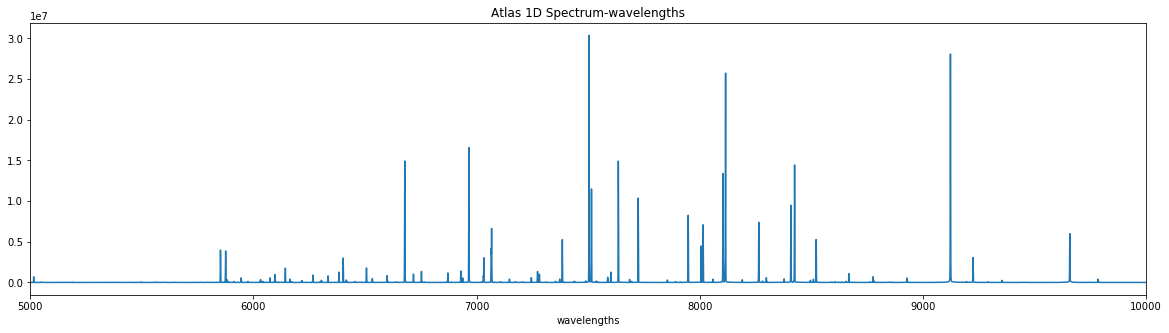

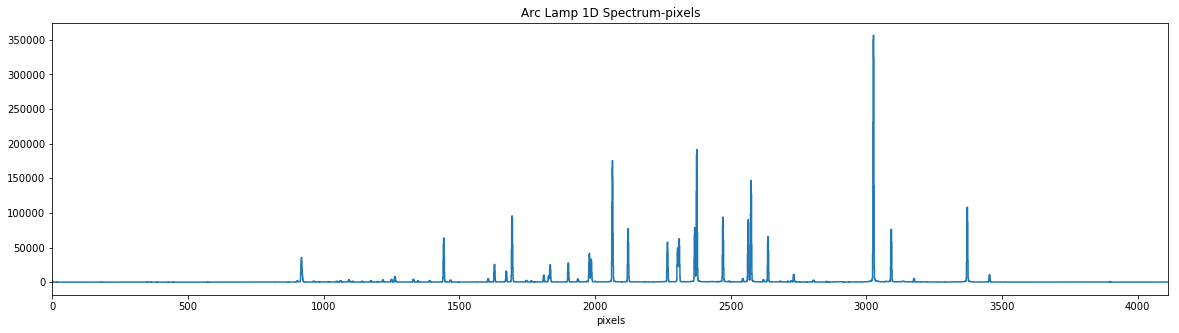

In [172]:
#generating atlas & arc graphs for wl & pixel matching

#nameing all the datafiles needed
all_side_files_red15 = '20170518/red*.fits' #redside
atlasfiles_red15 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red15 = '20170518/red0017.fits' #redside
linelist_red15 = reduce_dblspec.HENEAR_LINE_LIST #must be in this form cant use'henearhres.dat'-debug later
idtag = 'DomeFlat'

#naming pipeline output for guess_plot use
specset_red15 = dispersion(all_side_files_red15, atlasfiles_red15, arcfiles_red15, linelist_red15,idtag)

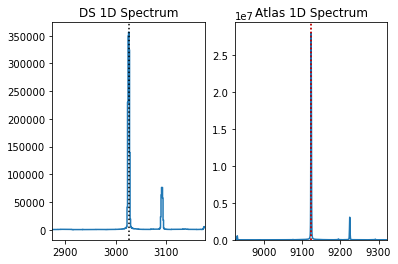

In [173]:
#collecting guesses of matching lines from above graphs

#entering (px,wl)guesses & data
guess_plot(3025.5,9122.9674,specset_red15) #outputs (pixel guess, nearest wl/id in linelist)


#collect those guesses here ~5 seems good
pixel_guesses_red15 = [3372,3027,2375,2065,1630]
atlas_lines_red15 = [9657.78,9122.9674,8115.31,7635.1,6965.43]
guesses_red15 = list(zip(pixel_guesses_red15, atlas_lines_red15)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Found line ArI at wl=8115.311
Clipped 0 lines
Failed to find line KrI at wl=8190.0543: "Tried to find peak at 2422.9794134689537 but it's in a valley, not a peak"
Found line ArI at wl=8264.5225
Clipped 0 lines
Failed to find line KrI at wl=8281.0495: "Guessed line's peak to base ratio is 1.0426190628335574, which is less than 10"
Failed to find line NeI at wl=8377.6065: "Guessed line's peak to base ratio is 7.738441232843095, which is less than 10"
Found line ArI at wl=8408.2096
Clipped 0 lines
Found line ArI at wl=8424.6475
Clipped 0 lines
Failed to find line NeI at wl=8495.3598: "Guessed line's peak to base ratio is 6.927245602779625, which is less than 10"
Failed to find line KrI at wl=8508.87: "Guessed line's peak to base ratio is 0.918376926620163, which is less than 10"
Found line ArI at wl=8521.4422
Clipped 0 lines
Failed to find line NeI at wl=8591.2583: "Guessed line's peak to base ratio is 3.0391380134241954, which is less than 10"
Failed to find line ArI at wl=8605.7762: "Gu

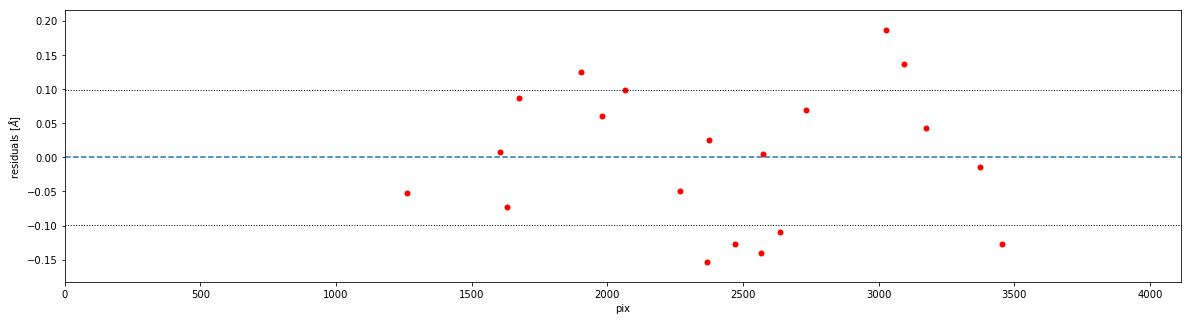

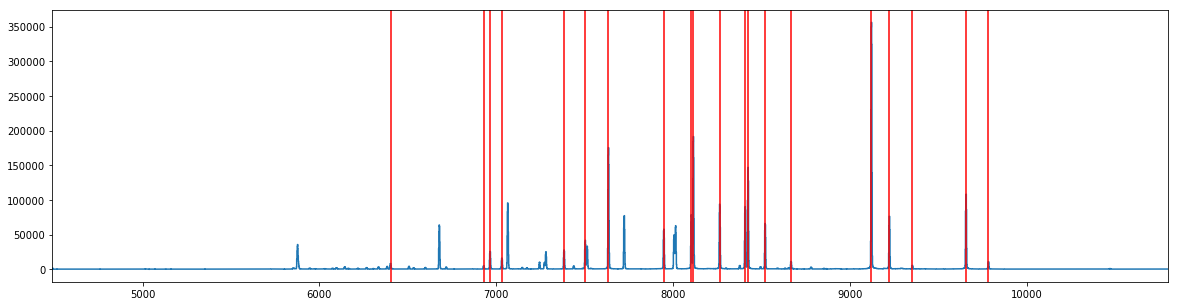

In [174]:
#generating more line matches based on guesses above and checking residuals to see if this is a good enough solution
flatid='DomeFlat'
ds_red15 = goodness_of_matches(arcfiles_red15,guesses_red15,all_side_files_red15,atlasfiles_red15,linelist_red15,flatid)

In [175]:
t=fits.open('DoubleSpec/20170518/blue0040.fits')
t[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  460 / length of data axis 1                          
NAXIS2  =                 2835 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBJECT  = 'DomeFlat'        

### Red (1.0") --ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


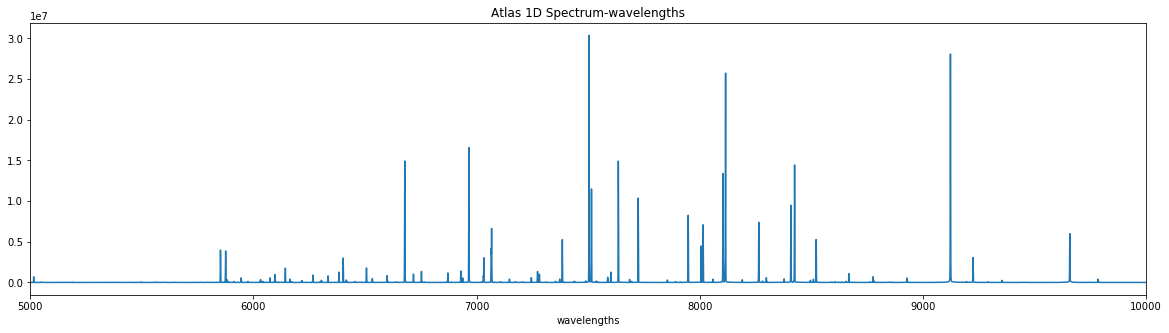

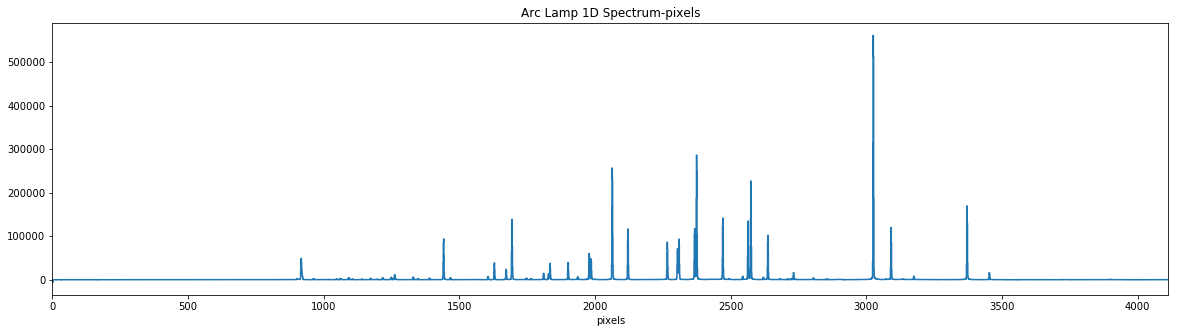

In [176]:
#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10,idtag)

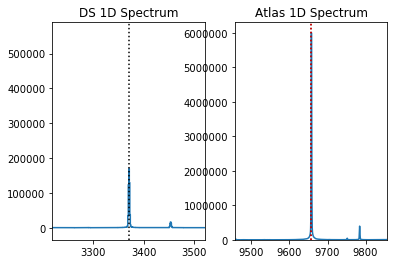

In [177]:
#collecting guesses of matching lines from above graphs

#entering (px,wl)guesses & data
guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 6.71869024521498, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 7.395561544387761, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Tried to find peak at 2338.0234170166977 but it's in a valley, not a peak"
Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed to find line KrI at wl=8190.0543: "Guessed line's peak to base ratio is 0.9423511275390428, which is less than 10"
Found line ArI at wl=8264.5225
Clipped 0 lines
Failed to find line KrI at wl=8281.0495: "Guessed line's peak to base ratio is 0.9588258798377841, which is less than 10"
Failed to find line NeI at wl=8377.6065: "Guessed line's peak to base ratio is 9.895947290981596, which is less than 10"
Found line ArI at wl=8408.2096
Clipped 0 lines
Found line ArI at wl=8424.6475
Clipped 0 li

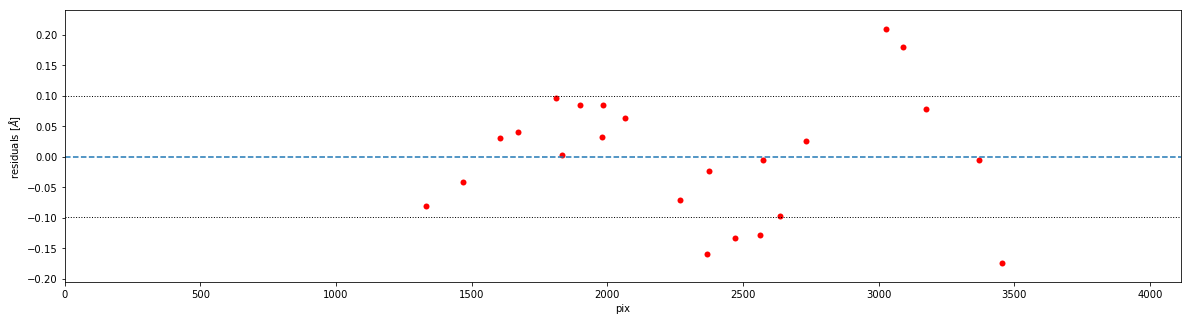

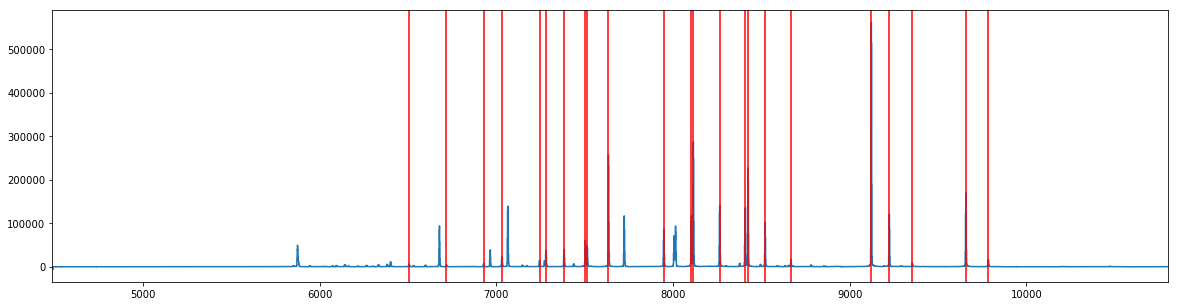

In [178]:
#generating more line matches based on guesses above and checking residuals to see if this is a good enough solution
flatid='DomeFlat'
ds_red10 = goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10,flatid)

### Blue (1.5") --ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side
not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...
b/c when use guess plot it appears in original orientation (which can be confusing at first)


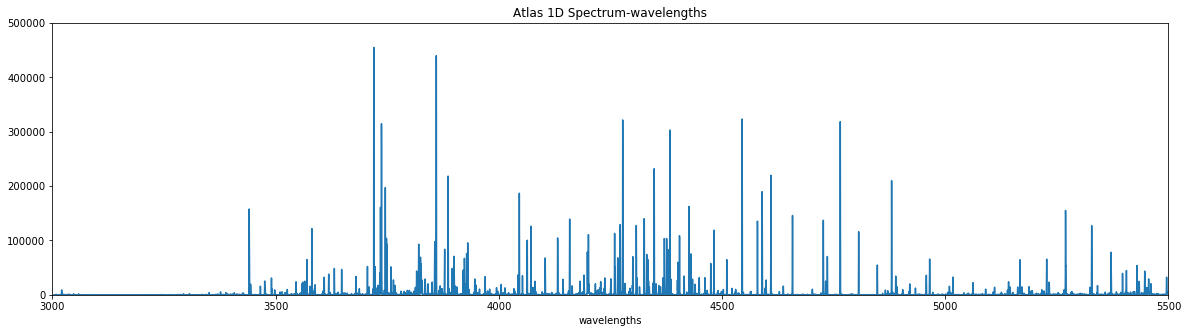

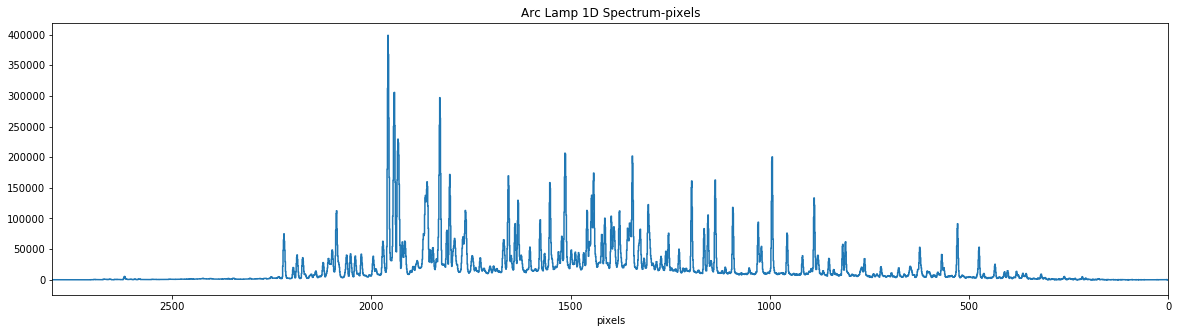

In [179]:
all_side_files_blue15 = '20170518/blue*.fits' #blueside
atlasfiles_blue15 = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles_blue15 = '20170518/blue0018.fits' #blueside
linelist_blue15 = reduce_dblspec.FEAR_LINE_LIST #must be in this form cant use'fear.dat'--debug later

specset_blue15 = dispersion(all_side_files_blue15, atlasfiles_blue15, arcfiles_blue15, linelist_blue15,idtag)
print ('not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...''\n'
       'b/c when use guess plot it appears in original orientation (which can be confusing at first)')

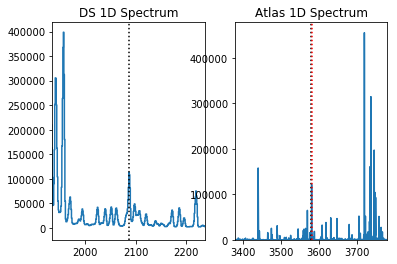

In [180]:
guess_plot(2086,3580,specset_blue15) #(px,wl)

#collect guesses here
pixel_guesses_blue15 = [529,993,1655,1956,2086]
atlas_lines_blue15 = [5269.5366,4764.8646,4044.4179,3719.9346,3581.1925] 

guesses_blue15 = list(zip(pixel_guesses_blue15, atlas_lines_blue15)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Guessed line's peak to base ratio is 0.7312268222798526, which is less than 5"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 3.6415429388607117, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 1.046308359334491, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Tried to find peak at 2599.234585866781 but it's in a valley, not a peak"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 0.9892623976573754, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 1.1518908065824378, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.4385738518614017, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.1305223236157673, which is le

Failed to find line ArII at wl=4052.9208: "Guessed line's peak to base ratio is 1.4787332773721624, which is less than 5"
Failed to find line FeI at wl=4063.5939: "Guessed line's peak to base ratio is 4.627867776925382, which is less than 5"
Failed to find line ArII at wl=4103.9121: "Guessed line's peak to base ratio is 3.7160970761380647, which is less than 5"
Failed to find line FeI at wl=4118.5442: "Guessed line's peak to base ratio is 1.5443084495886925, which is less than 5"
Failed to find line ArII at wl=4131.7235: "Guessed line's peak to base ratio is 4.689635553392686, which is less than 5"
Failed to find line FeI at wl=4143.8688: "Guessed line's peak to base ratio is 3.762403078165978, which is less than 5"
Found line ArI at wl=4158.5905
Clipped 0 lines
Failed to find line ArI at wl=4164.1795: "Guessed line's peak to base ratio is 1.1032350487903626, which is less than 5"
Failed to find line FeI at wl=4198.3036: "Guessed line's peak to base ratio is 4.086992227275349, which is

Found line FeI at wl=4957.5966
Clipped 0 lines
Found line ArII at wl=4965.0795
Clipped 0 lines
Failed to find line ArII at wl=4972.1597: "Guessed line's peak to base ratio is 1.4705974774310648, which is less than 5"
Failed to find line FeI at wl=5006.1175: "Tried to find peak at 772.9981998519175 but it's in a valley, not a peak"
Failed to find line ArII at wl=5009.3344: "Guessed line's peak to base ratio is 2.0017764212670275, which is less than 5"
Failed to find line FeI at wl=5012.0674: "Guessed line's peak to base ratio is 2.0017764212670275, which is less than 5"
Failed to find line ArII at wl=5017.1628: "Guessed line's peak to base ratio is 4.2796839501675485, which is less than 5"
Failed to find line FeI at wl=5051.6336: "Guessed line's peak to base ratio is 2.041141782811296, which is less than 5"
Failed to find line ArII at wl=5062.0371: "Guessed line's peak to base ratio is 3.8332955253105023, which is less than 5"
Failed to find line FeI at wl=5083.3377: "Guessed line's pea

Skipping line ArI at wl=7948.1964 - out of wl min/max
Skipping line ArI at wl=8006.1567 - out of wl min/max
Skipping line ArI at wl=8014.7857 - out of wl min/max
Skipping line ArI at wl=8037.2183 - out of wl min/max
Skipping line ArI at wl=8046.1169 - out of wl min/max
Skipping line ArI at wl=8053.3085 - out of wl min/max
Skipping line ArI at wl=8066.6046 - out of wl min/max
Skipping line ArI at wl=8103.6931 - out of wl min/max
Skipping line ArI at wl=8115.311 - out of wl min/max
Skipping line ArI at wl=8143.505 - out of wl min/max
Skipping line ArI at wl=8203.4352 - out of wl min/max
Skipping line ArI at wl=8264.5225 - out of wl min/max
Skipping line FeI at wl=8327.0526 - out of wl min/max
Skipping line ArI at wl=8384.724 - out of wl min/max
Skipping line FeI at wl=8387.77 - out of wl min/max
Skipping line ArI at wl=8408.2096 - out of wl min/max
Skipping line ArI at wl=8424.6475 - out of wl min/max
Skipping line ArI at wl=8490.3065 - out of wl min/max
Skipping line ArI at wl=8521.4422

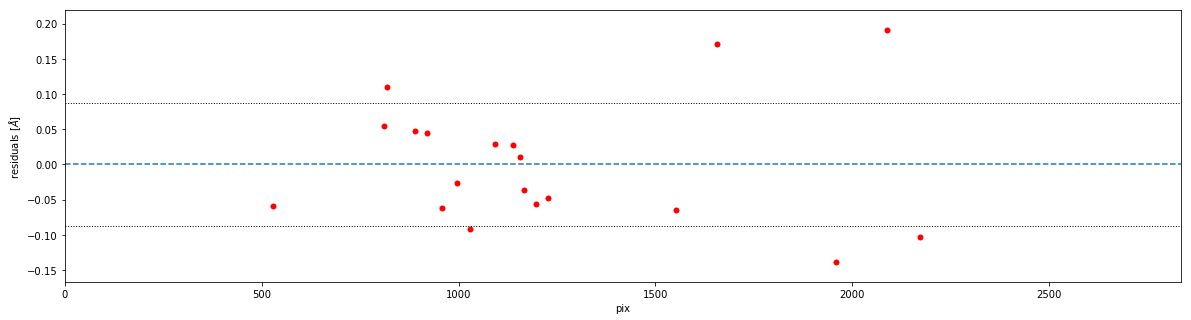

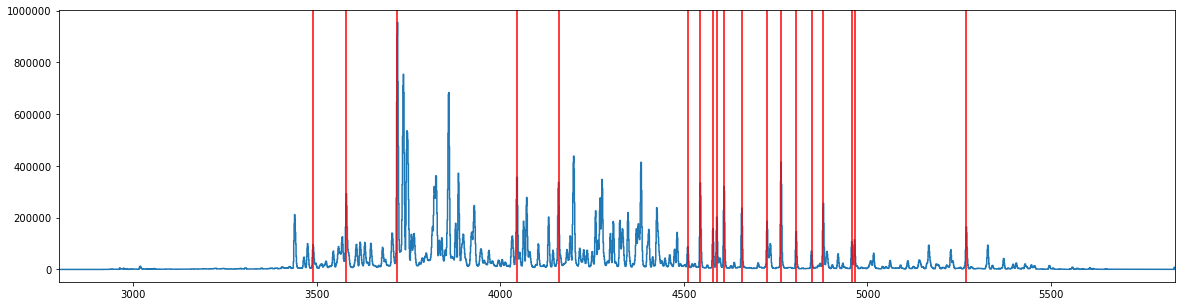

In [181]:
#generating more line matches based on guesses above and checking residuals to see if this is a good enough solution
flatid='DomeFlat'
ds_blue15 = goodness_of_matches(arcfiles_blue15,guesses_blue15,all_side_files_blue15,atlasfiles_blue15,linelist_blue15,flatid) #yay looks good FINALLY!!

### Blue (1.0") --ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side
not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...
b/c when use guess plot it appears in original orientation (which can be confusing at first)


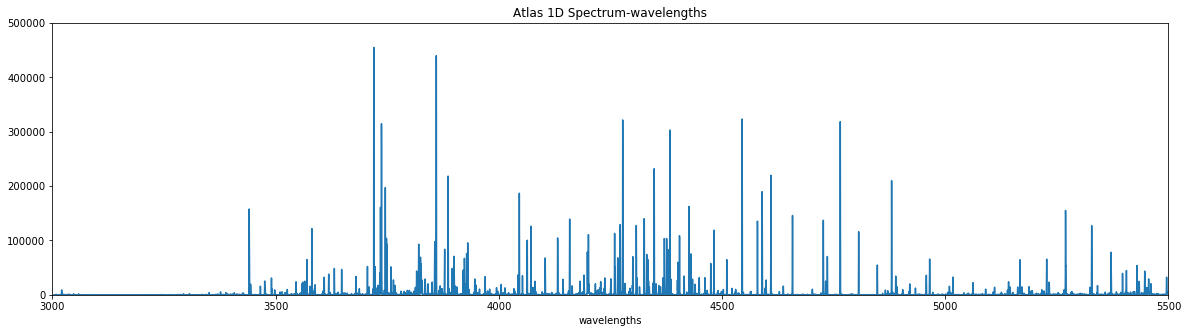

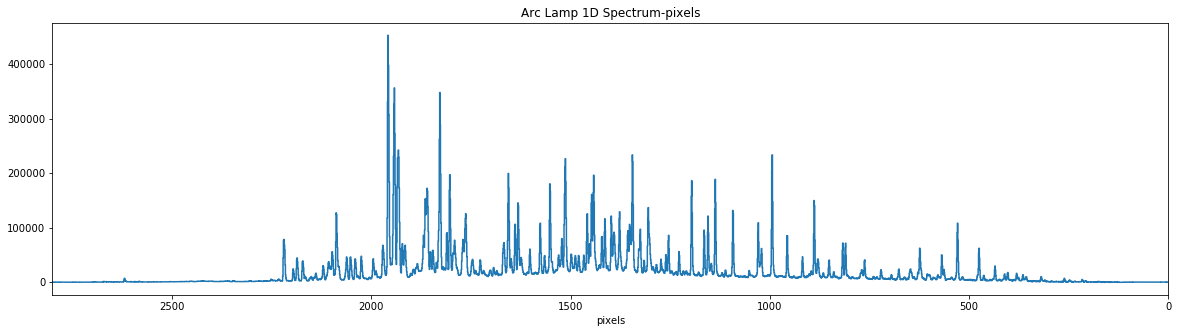

In [182]:
all_side_files_blue10 = '20170518/blue*.fits' #blueside
atlasfiles_blue10 = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles_blue10 = '20170518/blue0011.fits' #blueside
linelist_blue10 = reduce_dblspec.FEAR_LINE_LIST #must be in this form cant use'fear.dat'--debug later

specset_blue10 = dispersion(all_side_files_blue10, atlasfiles_blue10, arcfiles_blue10, linelist_blue10,idtag)
print ('not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...''\n'
       'b/c when use guess plot it appears in original orientation (which can be confusing at first)')

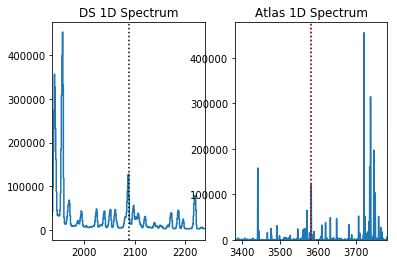

In [183]:
guess_plot(2088,3581,specset_blue10) #(px,wl)

#collect guesses here
pixel_guesses_blue10 = [1958,993,529,1602,1550,1254] 
atlas_lines_blue10 = [3719.9346,4764.8646,5266.5546,4103.91,4158.59,4481.81] 
guesses_blue10 = list(zip(pixel_guesses_blue10, atlas_lines_blue10)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Tried to find peak at 2622.141126221478 but it's in a valley, not a peak"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 3.884537599063041, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 0.9729875346430994, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Tried to find peak at 2595.9102217545324 but it's in a valley, not a peak"
Failed to find line FeI at wl=3057.4456: "Tried to find peak at 2586.3520807703403 but it's in a valley, not a peak"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.728611272165076, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.2953062119576328, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.2666965744164804, which is less than 5

Failed to find line FeI at wl=4005.2414: "Guessed line's peak to base ratio is 2.571218523673293, which is less than 5"
Failed to find line ArII at wl=4033.8093: "Guessed line's peak to base ratio is 2.028214879630224, which is less than 5"
Failed to find line ArII at wl=4042.8937: "Tried to find peak at 1658.8953305030093 but it's in a valley, not a peak"
Failed to find line ArI at wl=4044.4179: "Guessed line's peak to base ratio is 4.936185272975721, which is less than 5"
Failed to find line FeI at wl=4045.813: "Guessed line's peak to base ratio is 4.936185272975721, which is less than 5"
Failed to find line ArII at wl=4052.9208: "Guessed line's peak to base ratio is 2.235399486441574, which is less than 5"
Found line FeI at wl=4063.5939
Clipped 0 lines
Failed to find line ArII at wl=4103.9121: "Guessed line's peak to base ratio is 3.4834574940413576, which is less than 5"
Failed to find line FeI at wl=4118.5442: "Guessed line's peak to base ratio is 1.7117942081327338, which is less

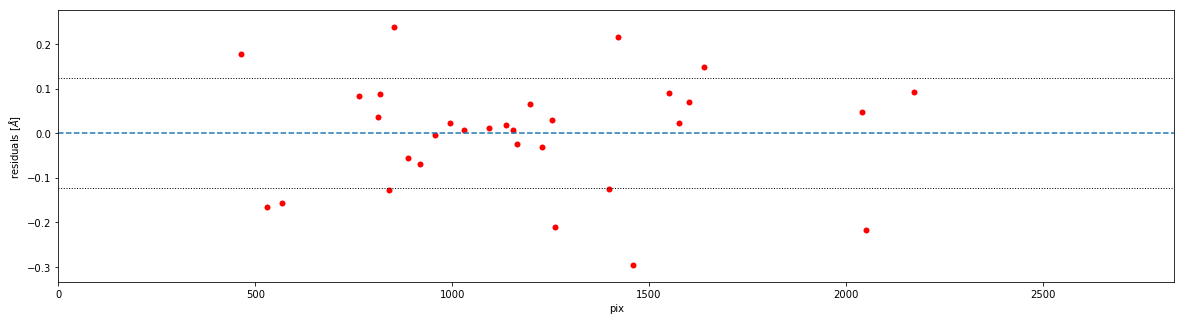

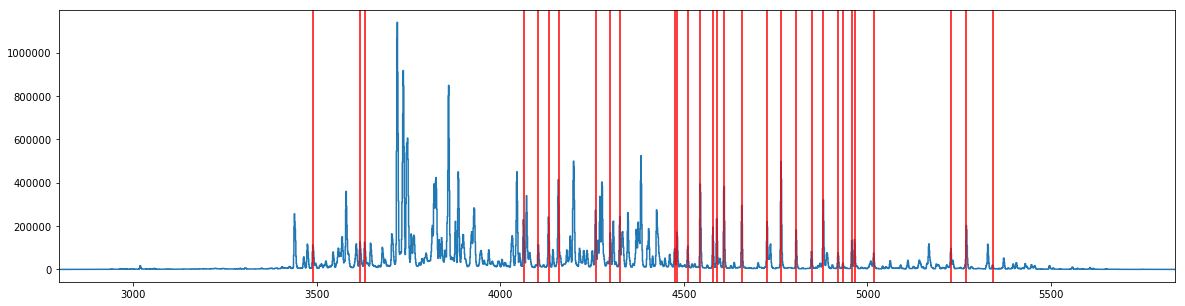

In [184]:
#generating more line matches based on guesses above and checking residuals to see if this is a good enough solution
flatid='DomeFlat'
ds_blue10 = goodness_of_matches(arcfiles_blue10,guesses_blue10,all_side_files_blue10,atlasfiles_blue10,linelist_blue10,flatid) #yay looks good FINALLY!!

# Sky Subtraction

### Ody_nospec -- Red (1.5") ss

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3 target files located


choose 2D spec for redside
choose 1D target spec axis limits for redside


(-100, 1000)

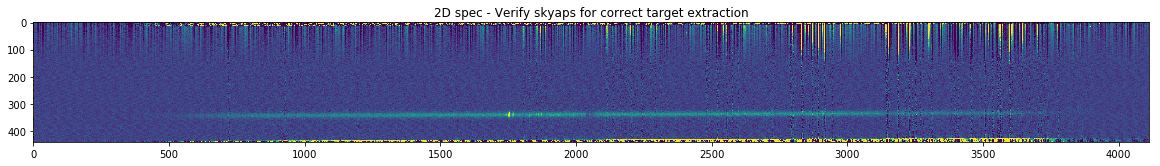

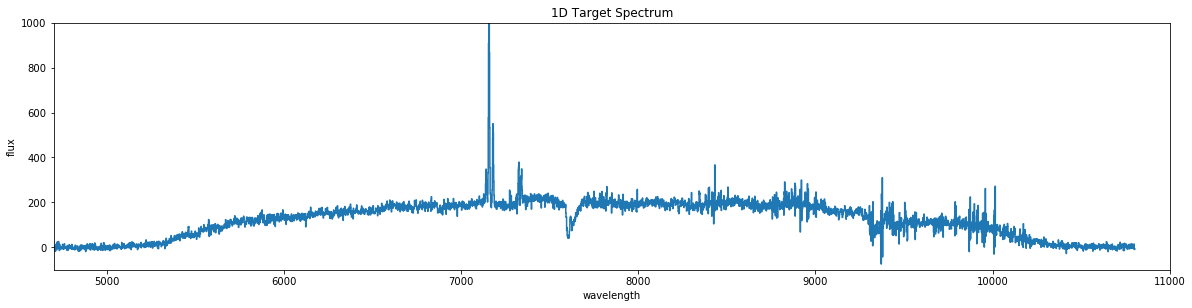

In [185]:
#naming files needed
targetID_red15 = 'Ody_nospec'
all_side_files_target = 'DoubleSpec/20170518/red*.fits' 
#skyaps_red15 = [(270,310),(380,410)]
skyaps_red15 = [(150,310),(380,410)]
specaps=(330,346)
vmax=40
vmin=-10
#model='linear'
model=('poly',3)
flux_red15,unc,comb = sky_subtract(targetID_red15,skyaps_red15,ds_red15,all_side_files_red15,atlasfiles_red15,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-100,1000)

### Ody_nospec -- Blue (1.5") ss 

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3 target files located


choose 2D spec for blueside
choose 1D target spec axis limits for blueside
WHY IS THERE NEGATIVE??


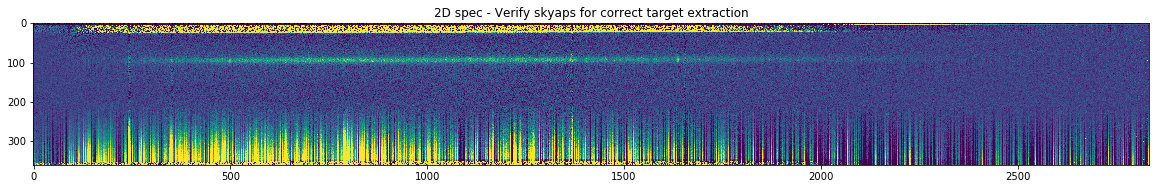

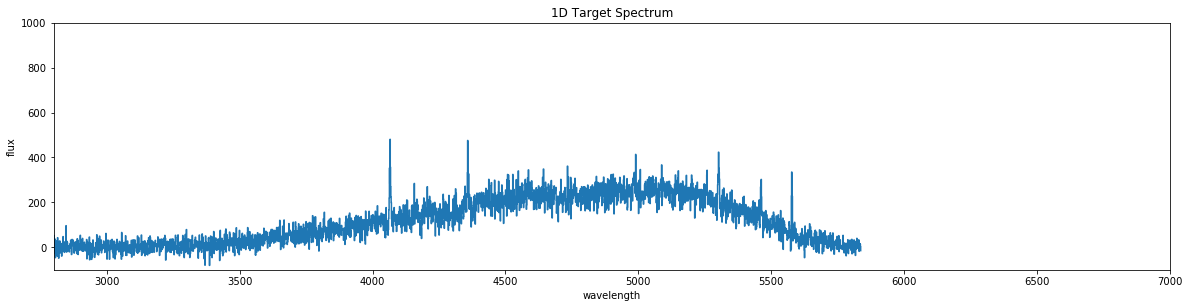

In [186]:
#naming files needed
targetID_blue15 = 'Ody_nospec'
#skyaps_blue15 = [(25,80),(135,215)]
###########skyaps_blue15 = [(25,80),(135,300)]

skyaps_blue15 = [(25,80),(135,215)]



specaps=(90,120)
#model='linear'
model=('poly',3)
flatid='DomeFlat'
all_side_files_target = 'DoubleSpec/20170518/blue*.fits'
flux_blue15,unc_blue15,comb = sky_subtract(targetID_blue15,skyaps_blue15,ds_blue15,all_side_files_blue15,atlasfiles_blue15,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-100,1000)
print('WHY IS THERE NEGATIVE??')

# Combining red & blue sides 
### Ody_nospec (1.5") --R/Bcombined 1D *need flux calibrations still*

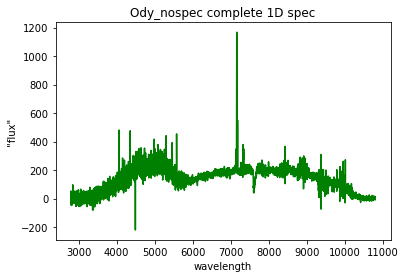

In [187]:
#SKIP

#TESTING combining red&blue sides BEFORE MAKING INTO A FCN

#applying the dispersion solutions for side & slit size
wl_red15 = ds_red15.pixtowl(np.arange(len(flux_red15)))
wl_blue15 = ds_blue15.pixtowl(np.arange(len(flux_blue15)))

#restructuring to work w/ interp & making cuts to avoid strange things at detector edges 
wl_blue15=wl_blue15[::-1] #this reverses the array to become increasing order
flux_blue15=flux_blue15[::-1] #need to also reverse this so associated vals agree w/ wl
flux_red15=flux_red15[2::] #chops off extreme val -1310.395.. & second extreme +1000 val
wl_red15=wl_red15[2::] #matched flux chop

#combining wls & flux for both sides
wl_both = np.concatenate([wl_red15, wl_blue15])
wl_both = np.sort(wl_both)   
rspec = np.interp(wl_both,wl_red15,flux_red15,left=0) #need to do so doesnt repeat first val
bspec = np.interp(wl_both,wl_blue15,flux_blue15,right=0) #need so doesnt repeat last val

#this is the actual adding step & plotting
rbspec = rspec + bspec
plt.xlabel('wavelength')
plt.ylabel('"flux"')
plt.title('Ody_nospec complete 1D spec')
#plt.step(wl_both, rbspec)
plt.plot(wl_both,rbspec,color='g') #very crazy, if change to black get blue const val prob but
#if its green or blue theres no problem...
#plt.xlim(4000,6500) #cant zoom in b/c same problem above. WTF

(0, 1236.5823901224137)

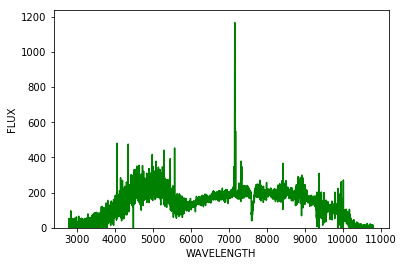

In [188]:
#SKIP

#saving figures for talk

#saving combined 1D & then added overlap graphs for talk
plt.plot(wl_both,rbspec,color='g')
plt.xlabel('WAVELENGTH')
plt.ylabel('FLUX')

#for overlap w/o adding
#plt.step(wl_blue15, flux_blue15,'b')
#plt.step(wl_red15,flux_red15,'r')
#plt.xlim(4000,6500)
#plt.ylim(0,600)
#plt.savefig('overlap.pdf', format='pdf', dpi=1200)

#for added overlap
#plt.ylim(0,600)
#plt.xlim(4000,6500)
#plt.savefig('added_overlap.pdf', format='pdf', dpi=1200)

#for 1D
plt.ylim(0,plt.ylim()[-1])
#plt.savefig('complete1D.pdf', format='pdf', dpi=1200)

this is flux: [-14.60848195   3.4221702   13.98910948 ...,  14.41409598  -9.56040108
  -6.49090407]


(array([-14.60848195,   3.4221702 ,  13.98910948, ...,  14.41409598,
         -9.56040108,  -6.49090407]),
 array([  2797.775653  ,   2798.80180994,   2799.8280411 , ...,
         10796.64942179,  10798.18967921,  10799.72992321]))

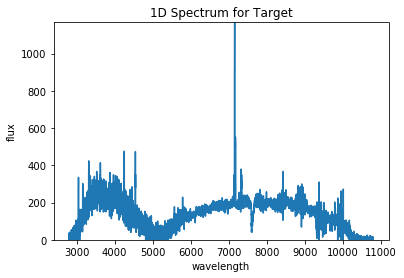

In [189]:
#KEEP
#fcn works to combine sides and returns flux w/ wl

combine_red_blue(ds_red15,ds_blue15,flux_red15,flux_blue15)
#why is it printing rbflux array ...oh b/c its returned by the fcn
##1st array is flux; 2nd array is wl

In [190]:
#saving stuff here incase git fucks me over
''' 

#okay trying again with cutting xarray to just around target...but doesnt this defeat the purpose?
#going back to original zero centered y data with x originals aka ytest & xtest
allzero = Table([ytest,xtest],names=('y','x')) #reusing
peak = max(allzero['y'])
peakrow = np.where(allzero['y']==peak)
#allzero[peakrow]
lower = int(peakrow-np.array(10))
upper = int(peakrow+np.array(10))
selectedx = allzero[lower:upper]
#selectedx #table of area around peak
#CAUTION! this will only work if theres only one peak!, wont detect multiple peaks
#------------------------------------------------------------------------------
#trying centroid around with only the subselected area around peak data
subx = selectedx['x']
suby = selectedx['y']
top_arr3 = suby * subx
top3 = sum(top_arr3)
bottom3 = sum(suby)
c = top3/bottom3
print('this is c:',c) #this might have worked!
#-----------------------------------------------------------------------------
plt.plot(xtest,ytest) #zero centered data
plt.plot(c,max(suby),'o',markersize=10) #centroid
plt.plot(x,y,'g') #original original data
plt.title('Centroid worked!!')
#----------------------------------------------------------------------------
#final test want to see if centroid will work w/o zero-centering y data

#nameing things
top_table2 = Table([x,y],names=('x','y')) #reusing this one with some amending
peak2 = max(top_table2['y'])
peakrow2 = np.where(top_table2['y']==peak2)
lower2 = int(peakrow2-np.array(10))
upper2 = int(peakrow2+np.array(10))
selectedx2 = top_table2[lower2:upper2]

#centroid method
subx2 = selectedx2['x']
suby2 = selectedx2['y']
top_arr4 = suby2 * subx2
top4 = sum(top_arr4)
bottom4 = sum(suby2)
c = top4/bottom4
print('this is c:',c) #interesting....this is close but not the same off by ~0.3

'''

" \n\n#okay trying again with cutting xarray to just around target...but doesnt this defeat the purpose?\n#going back to original zero centered y data with x originals aka ytest & xtest\nallzero = Table([ytest,xtest],names=('y','x')) #reusing\npeak = max(allzero['y'])\npeakrow = np.where(allzero['y']==peak)\n#allzero[peakrow]\nlower = int(peakrow-np.array(10))\nupper = int(peakrow+np.array(10))\nselectedx = allzero[lower:upper]\n#selectedx #table of area around peak\n#CAUTION! this will only work if theres only one peak!, wont detect multiple peaks\n#------------------------------------------------------------------------------\n#trying centroid around with only the subselected area around peak data\nsubx = selectedx['x']\nsuby = selectedx['y']\ntop_arr3 = suby * subx\ntop3 = sum(top_arr3)\nbottom3 = sum(suby)\nc = top3/bottom3\nprint('this is c:',c) #this might have worked!\n#-----------------------------------------------------------------------------\nplt.plot(xtest,ytest) #zero cen

# Flux calibrations


## and how to actually calibrate since stars have so little noise that signal hovers by zero away from emission lines...but galaxies dont do that so itd be a drastic subtraction....think and then also ask erik

# watch the logs for correct date...all named log.csv but below are correct for date

In [191]:
#begin by reducing a standard star GD 153 on night 5/18/17
#red side first and 1.5" so frames 61 & 62
targetID_red15 = 'GD 153'
skyaps_red15 = [(270,310),(380,410)]
#skyaps_red15 = [(80,310),(220,410)]


#fix below need more inputs b/c amended pipeline
##flux_red15_star,unc_star = sky_subtract(targetID_red15,skyaps_red15,ds_red15,all_side_files_red15,atlasfiles_red15,vmax,vmin)

In [192]:
#naming files needed
targetID_blue15 = 'GD 153'
skyaps_blue15 = [(25,80),(135,215)]
#skyaps_blue15 = [(100,80),(165,215)]

#amend below missing inputs
##flux_blue15,unc_blue15 = sky_subtract(targetID_blue15,skyaps_blue15,ds_blue15,all_side_files_blue15,atlasfiles_blue15,vmax,vmin)



# Targets - sky subtract & combine

## SD-2 Red1.0"

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located


choose 2D spec for redside
choose 1D target spec axis limits for redside


(-200, 1000)

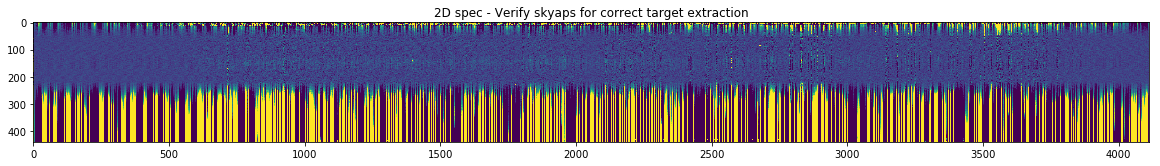

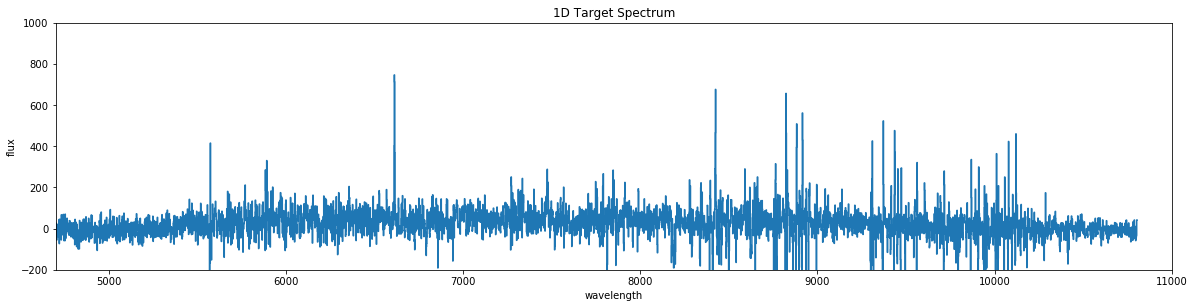

In [193]:
targetID_red10 = '68298203070473-ScoobyDoo'
all_side_files_target = 'DoubleSpec/20170518/red*.fits' 
#skyaps_red15 = [(270,310),(380,410)]
##skyaps_red10 = [(60,120),(170,200)]
skyaps_red10 = [(50,120),(175,220)]


all_side_files_target='DoubleSpec/20170518/red*.fits'
flatid='DomeFlat'
specaps=(125,170)
vmax=40
vmin=-10
#model='linear'
model=('poly',5)
flux_red10_SD2,unc,comb = sky_subtract(targetID_red10,skyaps_red10,ds_red10,all_side_files_red10,atlasfiles_red10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-200,1000)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located


choose 2D spec for blueside
choose 1D target spec axis limits for blueside


(-100, 1000)

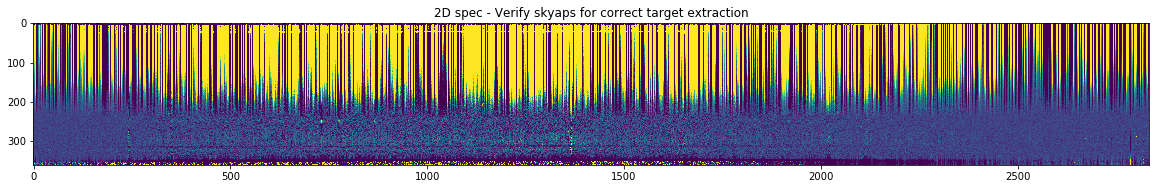

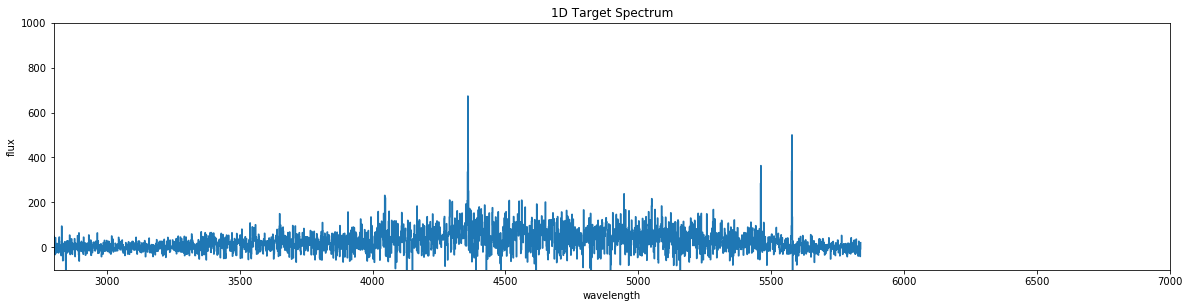

In [194]:
#naming files needed
targetID_blue10 = '68298203070473-ScoobyDoo'
#skyaps_blue15 = [(55,275),(310,360)]
##skyaps_blue10 = [(255,275),(310,330)]
skyaps_blue10 = [(235,275),(310,335)]


specaps=(280,305)
#model='linear'
model=('poly',3)
flatid='DomeFlat'
all_side_files_target = 'DoubleSpec/20170518/blue*.fits'
flux_blue10_SD2,unc_blue10,comb = sky_subtract(targetID_blue10,skyaps_blue10,ds_blue10,all_side_files_blue10,atlasfiles_blue10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-100,1000)

this is flux: [ -6.38091751  13.04356702  10.64452145 ..., -41.29894152 -31.88964966
  42.06921788]


(array([ -6.38091751,  13.04356702,  10.64452145, ..., -41.29894152,
        -31.88964966,  42.06921788]),
 array([  2797.91469808,   2798.93917689,   2799.96373233, ...,
         10800.94217958,  10802.48352352,  10804.02485553]))

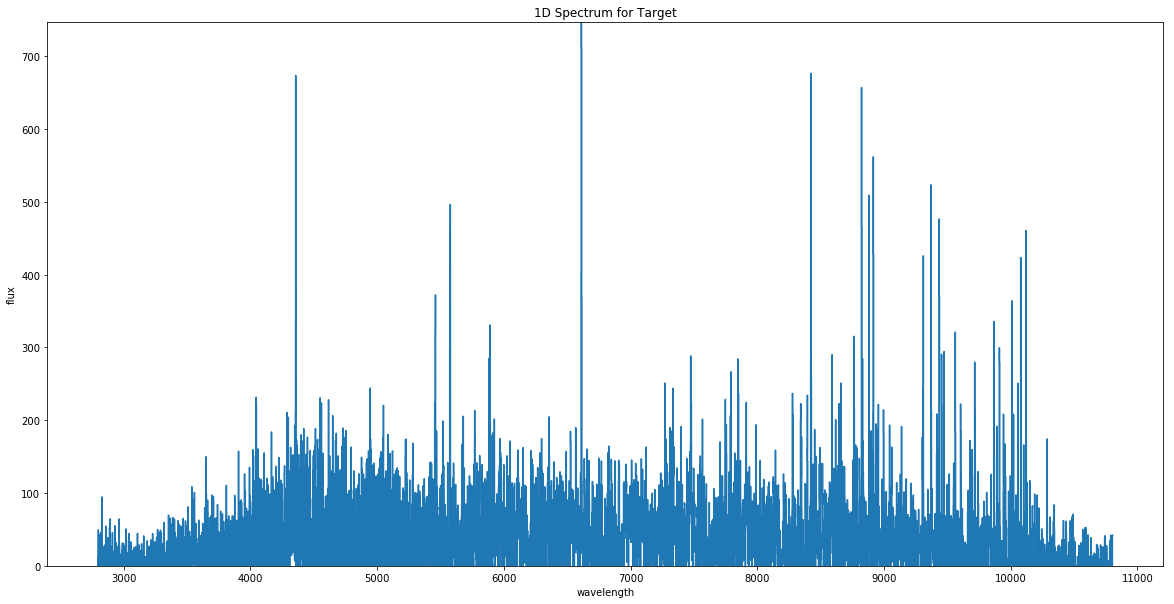

In [195]:
plt.figure(figsize=(20,10))
combine_red_blue(ds_red10,ds_blue10,flux_red10_SD2,flux_blue10_SD2)

# G-2  1.0"

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3 target files located


choose 2D spec for blueside
choose 1D target spec axis limits for blueside


(2700, 6000)

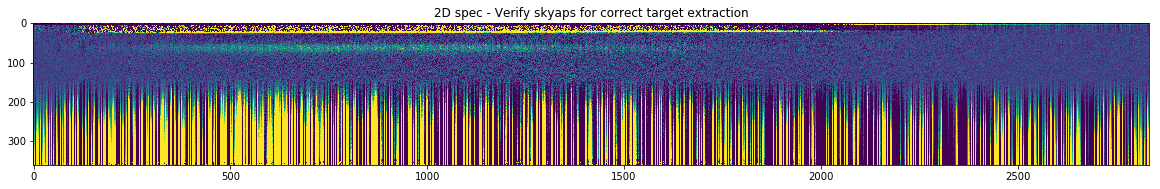

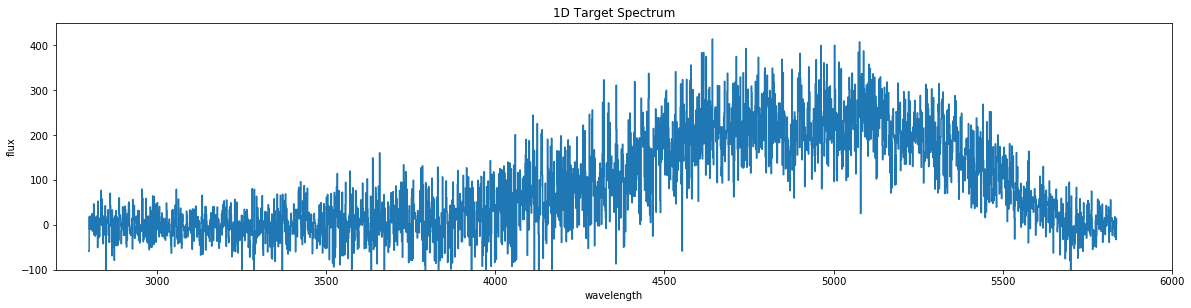

In [196]:
#naming files needed
targetID_blue10 = '65566078402826-Gilgamesh'
#skyaps_blue15 = [(55,275),(310,360)]
##skyaps_blue10 = [(255,275),(310,330)]
###skyaps_blue10 = [(205,235),(290,350)]
skyaps_blue10=[(75,145),(25,42)]#[(75,100),(130,170)]


#specaps=(305,325) #1st target of 2 based on raw imgs
##specaps=(104,120) #try this other target
###specaps=(230,265)##specaps=(220,280) #based on 2d spec
specaps=(42,73)


#model='linear'
model=('poly',3)
flatid='DomeFlat'
all_side_files_target = 'DoubleSpec/20170518/blue*.fits'
flux_blue10_G2,unc_blue10,comb = sky_subtract(targetID_blue10,skyaps_blue10,ds_blue10,all_side_files_blue10,atlasfiles_blue10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-100,450)
plt.xlim(2700,6000)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3 target files located


choose 2D spec for redside
choose 1D target spec axis limits for redside


(-200, 1000)

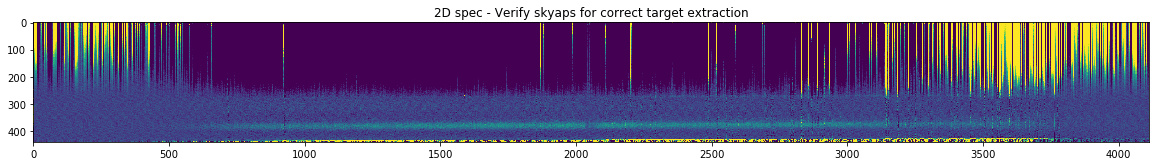

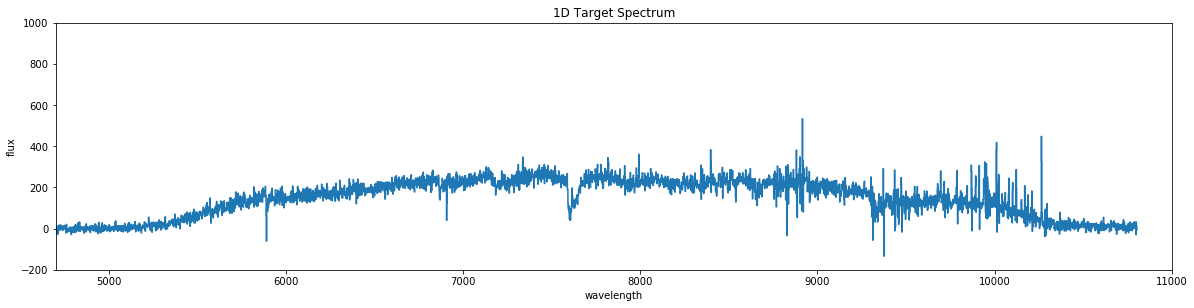

In [197]:
targetID_red10 = '65566078402826-Gilgamesh'
all_side_files_target = 'DoubleSpec/20170518/red*.fits' 
##skyaps_red10 = [(300,365),(395,410)]
#skyaps_red10 = [(300,360),(392,425)]
skyaps_red10 = [(275,350),(392,427)] #[(180,250)



all_side_files_target='DoubleSpec/20170518/red*.fits'
flatid='DomeFlat'
##specaps=(370,390)
specaps=(365,390)


vmax=40
vmin=-10
#model='linear'
model=('poly',3)
flux_red10_G2,unc,comb = sky_subtract(targetID_red10,skyaps_red10,ds_red10,all_side_files_red10,atlasfiles_red10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-200,1000)

this is flux: [-58.55132517  18.04733102  -9.63616084 ...,  31.55737486  12.467616
  -4.86801177]


(-100, 700)

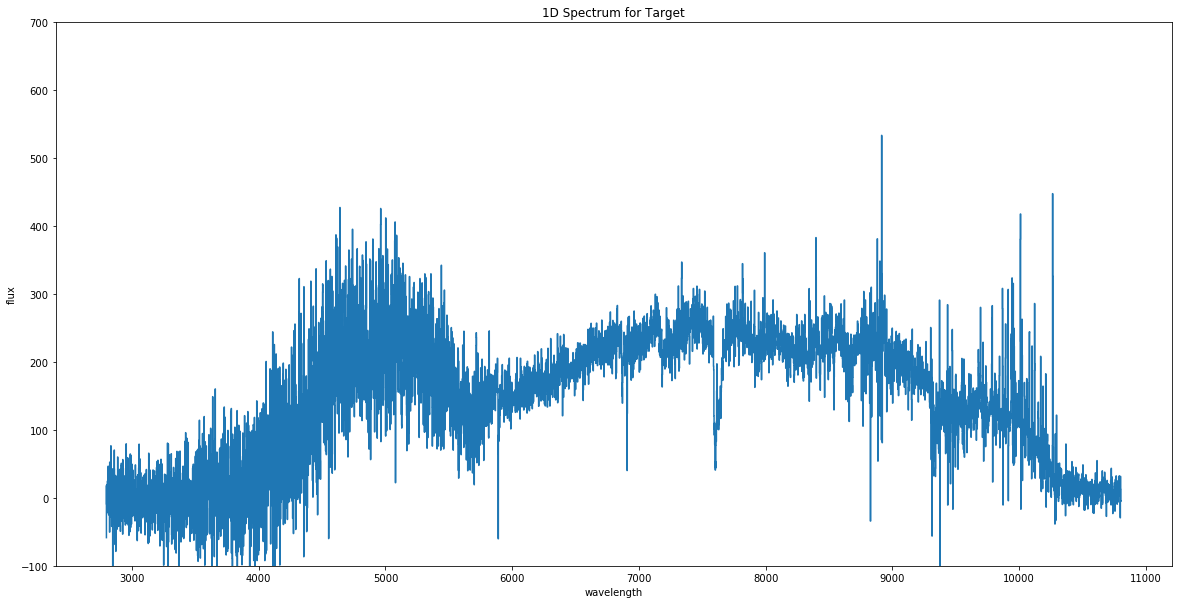

In [198]:
plt.figure(figsize=(20,10))
combine_red_blue(ds_red10,ds_blue10,flux_red10_G2,flux_blue10_G2)
plt.ylim(-100,700)

# ---------------- ***START HERE*** ------------------

# Catch22-1 1.0"

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5 target files located


choose 2D spec for blueside
choose 1D target spec axis limits for blueside


(-100, 1000)

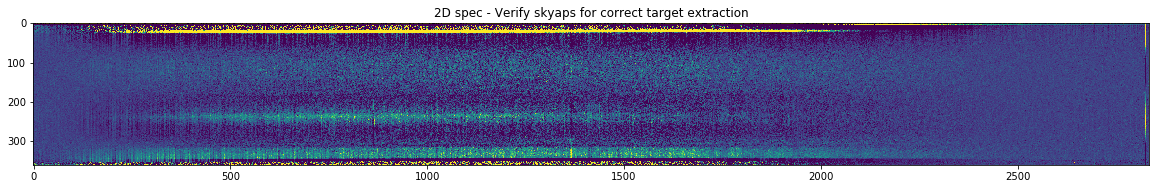

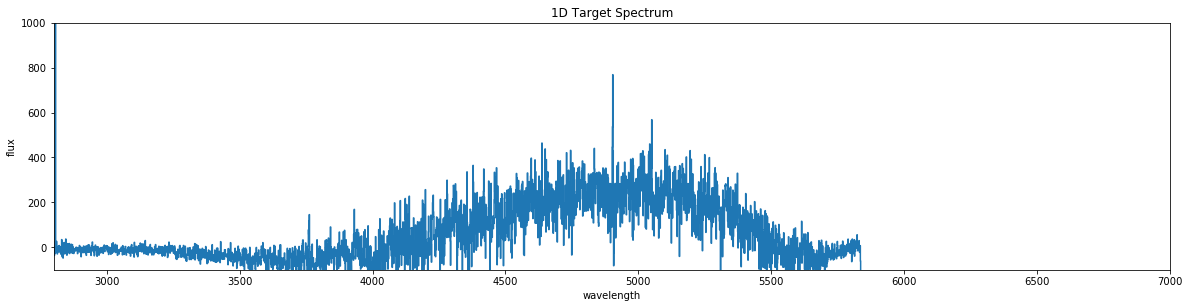

In [199]:
#naming files needed
targetID_blue10 = '79005021831220-Catch22'
skyaps_blue10=[(55,230),(280,400)]#[(75,100),(130,170)]
##skyaps_blue10=[(100,250),(310,330)]

#specaps=(100,200)
##specaps=(270,300)
specaps=(230,260)

#model='linear'
model=('cheb',3)
flatid='DomeFlat'
all_side_files_target = 'DoubleSpec/20170518/blue*.fits'
flux_blue10_C22_1,unc_blue10,comb = sky_subtract(targetID_blue10,skyaps_blue10,ds_blue10,all_side_files_blue10,atlasfiles_blue10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-100,1000)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5 target files located


choose 2D spec for redside
choose 1D target spec axis limits for redside


(-500, 8000)

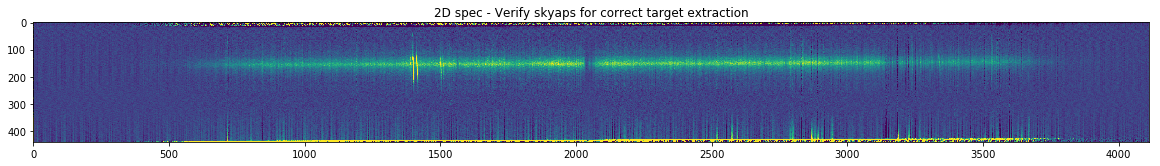

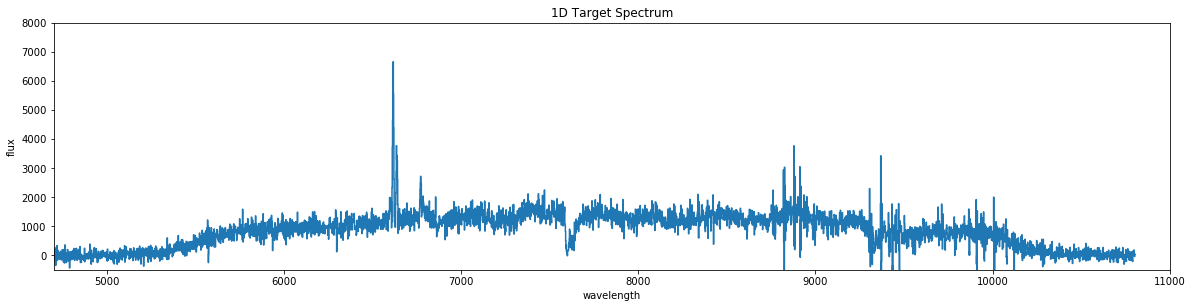

In [200]:
targetID_red10 = '79005021831220-Catch22' 
all_side_files_target = 'DoubleSpec/20170518/red*.fits' 
##skyaps_red10 = [(300,365),(395,410)]
#skyaps_red10 = [(300,360),(392,425)]
###############skyaps_red10 = [(65,145),(185,300)] #[(180,250)
skyaps_red10 = [(20,44),(265,320)]#(265,370)] #[(65,100),(195,300)] 20,25 

#260-300
all_side_files_target='DoubleSpec/20170518/red*.fits'
flatid='DomeFlat'
##specaps=(370,390)
##############specaps=(150,180)
specaps=(45,260)#(110,190)35
vmax=40
vmin=-10
#model='linear'
model=('poly',2)
flux_red10_C22_1,unc,comb = sky_subtract(targetID_red10,skyaps_red10,ds_red10,all_side_files_red10,atlasfiles_red10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-500,8000)
##print('note that around wl-6600 there are ')#possible emission lines (wl~6600)with doppler shift visible spatially(32-266)

this is flux: [ 26.45747458 -18.23293286 -14.19207316 ...,  -5.00742298 -43.5888934
  36.51485732]


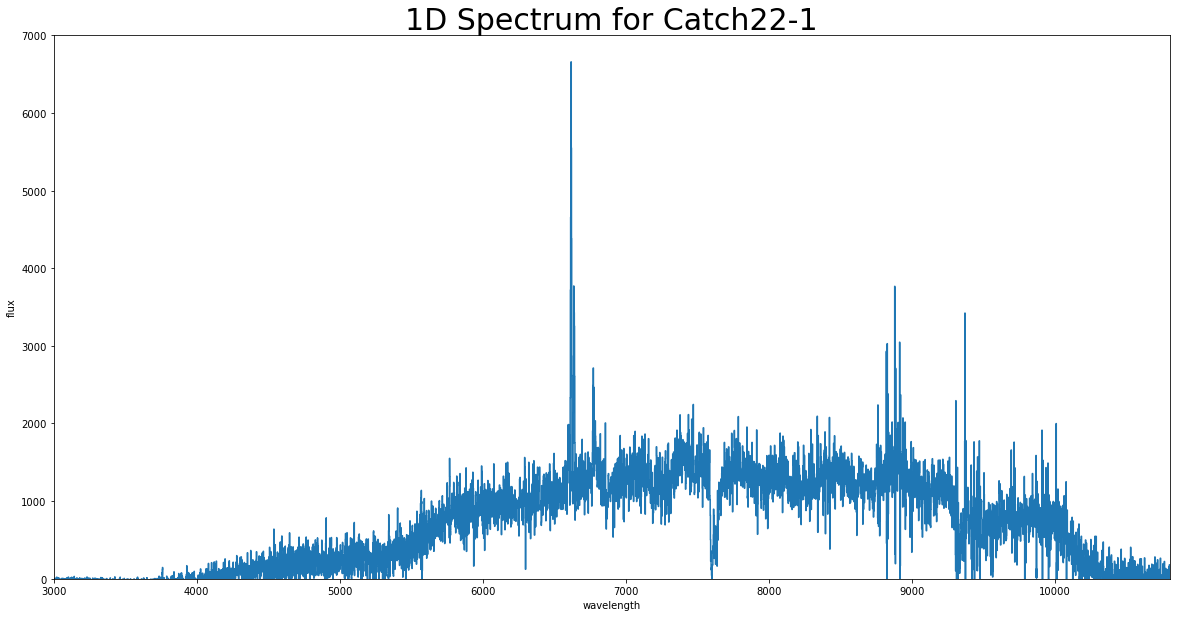

In [201]:
plt.figure(figsize=(20,10))
C22_1_flux, C22_1_wl =combine_red_blue(ds_red10,ds_blue10,flux_red10_C22_1,flux_blue10_C22_1)
plt.ylim(0,7000)
plt.xlim(3000,10800)
plt.title('1D Spectrum for Catch22-1',fontsize=30)

In [202]:
C22_1=Table([C22_1_flux,C22_1_wl], names=('flux','wl'))
C22_1['row no.']=np.arange(0,len(C22_1))
C22_1[1589:1591]

<Table length=2>
     flux           wl      row no.
   float64       float64     int64 
------------- ------------- -------
-81.513003038 4492.19499615    1589
28.5984404048 4493.28396939    1590

In [203]:
#for i in flux_red10_C22_1:
#    if i > 8000.0:
#        print (i)

In [204]:
#for i in flux_blue10_C22_1:
#    if i > 8000.0:
#        print (i)  

In [205]:
#import reduce_dblspec 
#plt.step(ds_red10.pixtowl(np.arange(len(flux_red10_C22_1))), flux_red10_C22_1)



In [206]:
#plt.step(flux_red10_C22_1, np.arange(len(flux_red10_C22_1)))

In [207]:
#for i in flux_red10_C22_1[0:15]:
#    print(i)

In [208]:
#C22_1[4189:4210] #halpha range 6560
C22_1[4221:4234]

<Table length=13>
     flux           wl      row no.
   float64       float64     int64 
------------- ------------- -------
948.417770042 6608.17822933    4221
1163.33067845 6609.71225861    4222
2330.83536825  6611.2463052    4223
3717.28038919 6612.78036907    4224
4656.53433465 6614.31445021    4225
5838.51931378 6615.84854863    4226
6656.86844263 6617.38266429    4227
5547.71806731 6618.91679721    4228
4378.19771864 6620.45094735    4229
2617.36768153 6621.98511472    4230
1347.43154171 6623.51929931    4231
 1129.0360977 6625.05350109    4232
1381.41918634 6626.58772007    4233

# Trying on my own to do the doppler shift comparison of C22-1 spectrum - at least visually first

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5 target files located


choose 2D spec for blueside
choose 1D target spec axis limits for blueside


(-100, 1000)

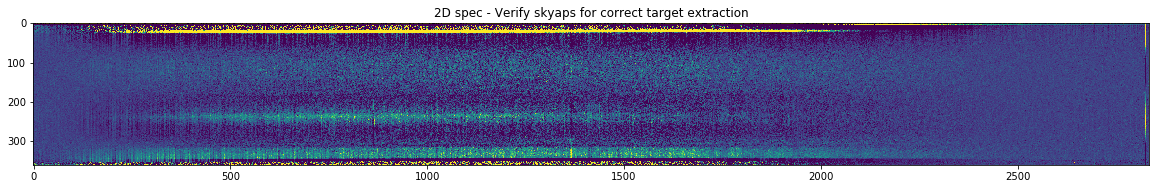

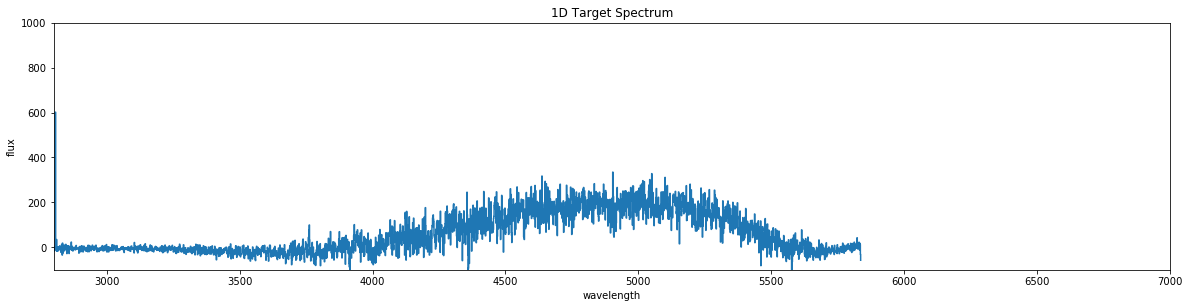

In [209]:
#TOP HALF


#literally just taking half of original spec aps
#naming files needed
targetID_blue10 = '79005021831220-Catch22'
skyaps_blue10=[(55,230),(280,400)]
specaps=(230,245)#original(230,260)
model=('cheb',3)
flatid='DomeFlat'
all_side_files_target = 'DoubleSpec/20170518/blue*.fits'
flux_blue10_C22_1_top,unc_blue10,comb = sky_subtract(targetID_blue10,skyaps_blue10,ds_blue10,all_side_files_blue10,atlasfiles_blue10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-100,1000)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5 target files located


choose 2D spec for redside
choose 1D target spec axis limits for redside


(-500, 8000)

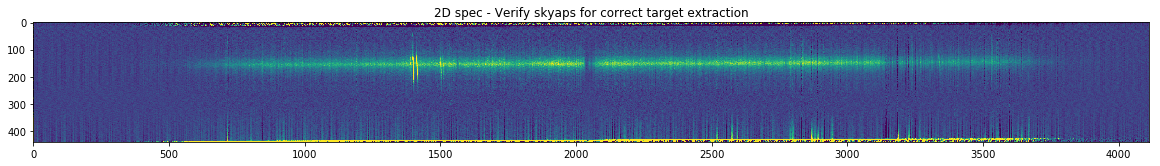

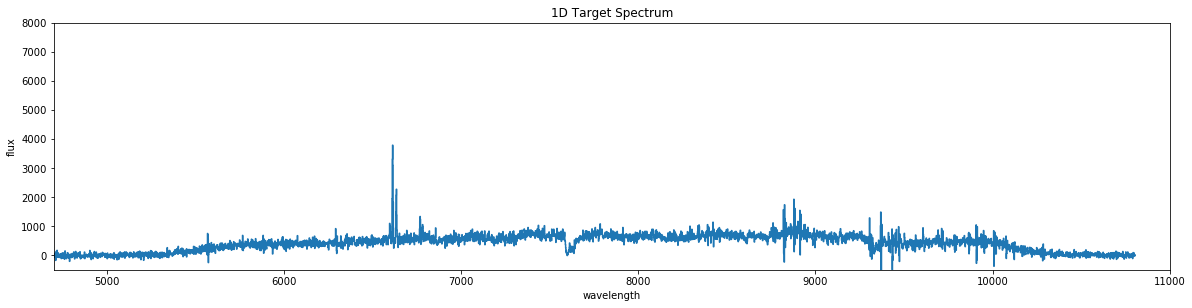

In [210]:
#TOP HALF

targetID_red10 = '79005021831220-Catch22' 
all_side_files_target = 'DoubleSpec/20170518/red*.fits' 
skyaps_red10 = [(20,44),(265,320)] 
all_side_files_target='DoubleSpec/20170518/red*.fits'
flatid='DomeFlat'
specaps= (45,152)#original(45,260)
vmax=40
vmin=-10
#model='linear'
model=('poly',2)
flux_red10_C22_1_top,unc,comb = sky_subtract(targetID_red10,skyaps_red10,ds_red10,all_side_files_red10,atlasfiles_red10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-500,8000)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5 target files located


choose 2D spec for blueside
choose 1D target spec axis limits for blueside


(-100, 1000)

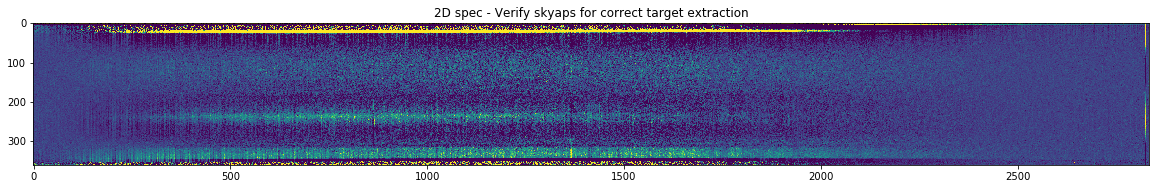

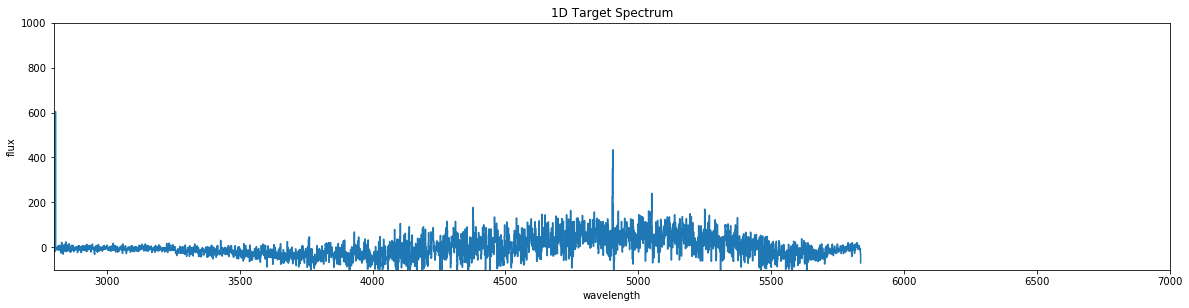

In [211]:
#BOTTOM. HALF


#literally just taking half of original spec aps
#naming files needed
targetID_blue10 = '79005021831220-Catch22'
skyaps_blue10=[(55,230),(280,400)]
specaps=(245,260)#original(230,260)
model=('cheb',3)
flatid='DomeFlat'
all_side_files_target = 'DoubleSpec/20170518/blue*.fits'
flux_blue10_C22_1_bottom,unc_blue10,comb = sky_subtract(targetID_blue10,skyaps_blue10,ds_blue10,all_side_files_blue10,atlasfiles_blue10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-100,1000)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5 target files located


choose 2D spec for redside
choose 1D target spec axis limits for redside


(-500, 8000)

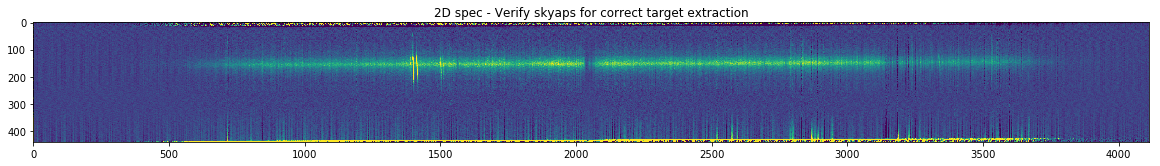

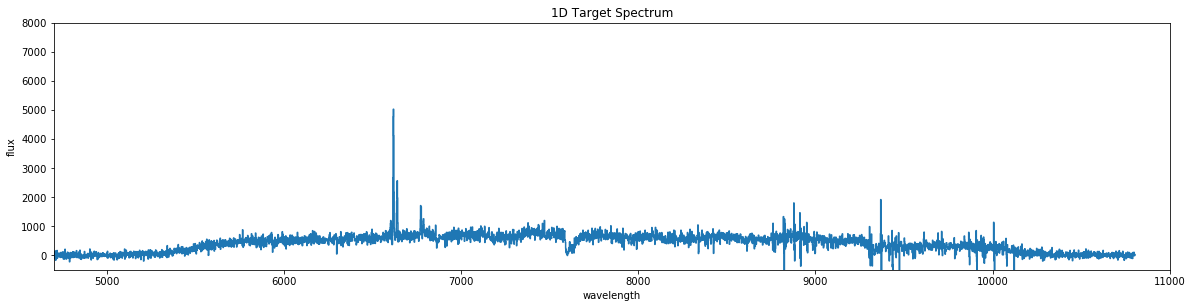

In [212]:
#BOTTOM HALF

targetID_red10 = '79005021831220-Catch22' 
all_side_files_target = 'DoubleSpec/20170518/red*.fits' 
skyaps_red10 = [(20,44),(265,320)] 
all_side_files_target='DoubleSpec/20170518/red*.fits'
flatid='DomeFlat'
specaps= (153,260)#original(45,260)
vmax=40
vmin=-10
#model='linear'
model=('poly',2)
flux_red10_C22_1_bottom,unc,comb = sky_subtract(targetID_red10,skyaps_red10,ds_red10,all_side_files_red10,atlasfiles_red10,all_side_files_target,flatid,specaps,vmax,vmin,model)
plt.ylim(-500,8000)

this is flux: [  5.17467847  -4.42130158  -3.5330692  ...,  12.11487096 -31.82942755
  12.24191888]


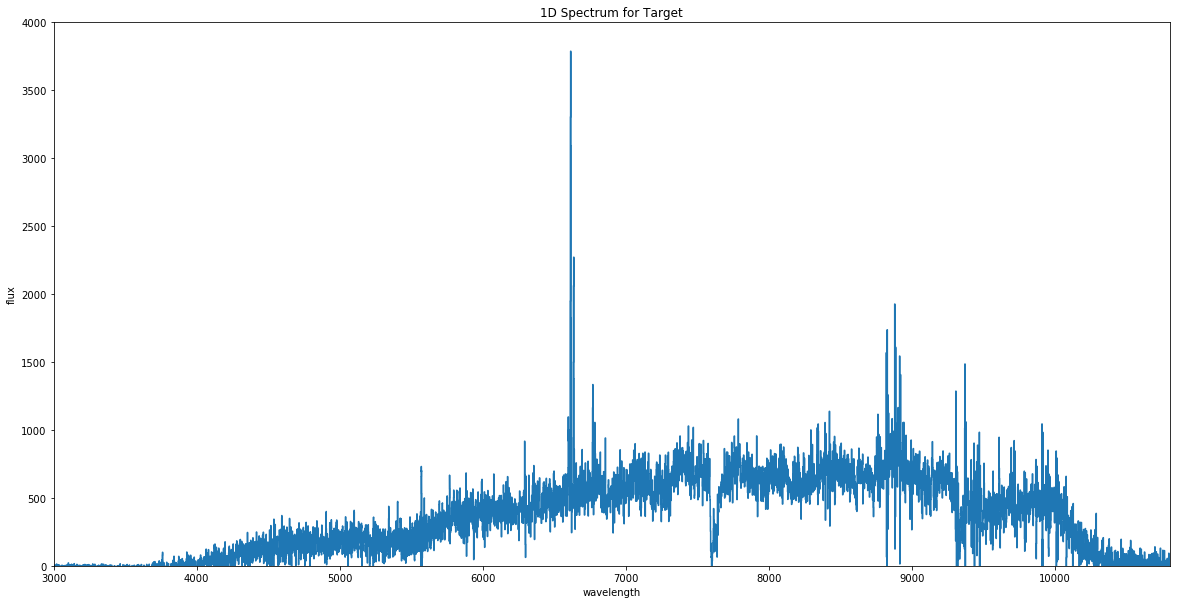

In [213]:
#combining r/b for top & making data to table

plt.figure(figsize=(20,10))
C22_1_flux_top, C22_1_wl_top =combine_red_blue(ds_red10,ds_blue10,flux_red10_C22_1_top,flux_blue10_C22_1_top)
plt.ylim(0,4000)
plt.xlim(3000,10800)

C22_1_top=Table([C22_1_flux_top,C22_1_wl_top], names=('flux','wl'))
C22_1_top['row no.']=np.arange(0,len(C22_1_top))

this is flux: [ 21.28279611 -13.81163128 -10.65900396 ..., -16.13324168 -12.42911593
  23.39051975]


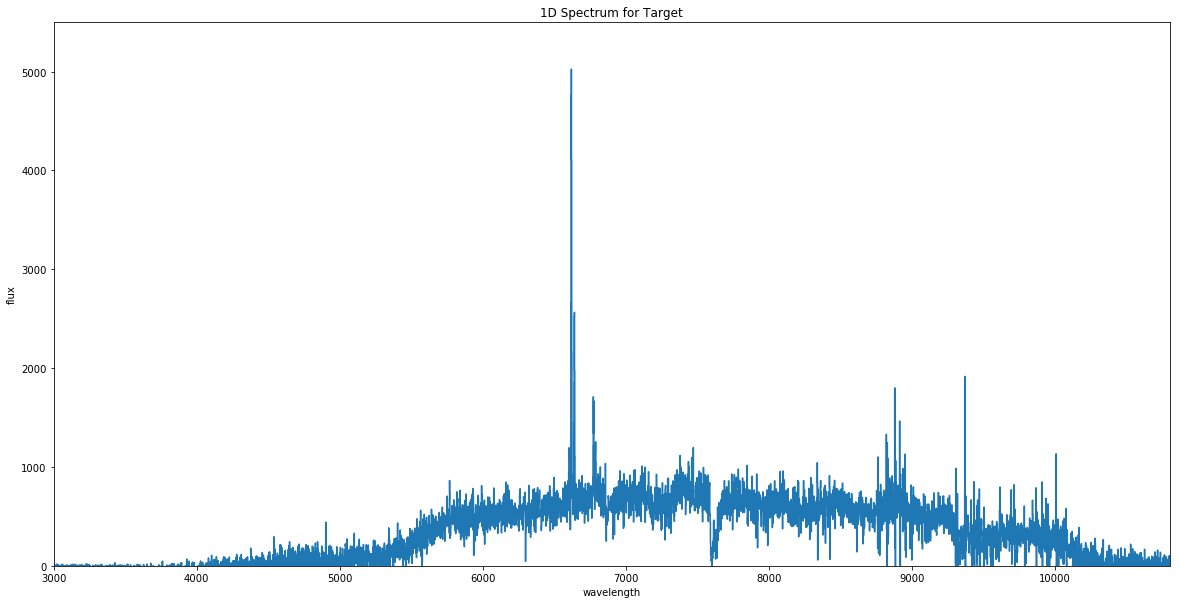

In [214]:
#combining r/b for bottom & making data to table

plt.figure(figsize=(20,10))
C22_1_flux_bottom, C22_1_wl_bottom =combine_red_blue(ds_red10,ds_blue10,flux_red10_C22_1_bottom,flux_blue10_C22_1_bottom)
plt.ylim(0,5500)
plt.xlim(3000,10800)

C22_1_bottom=Table([C22_1_flux_bottom,C22_1_wl_bottom], names=('flux','wl'))
C22_1_bottom['row no.']=np.arange(0,len(C22_1_bottom))


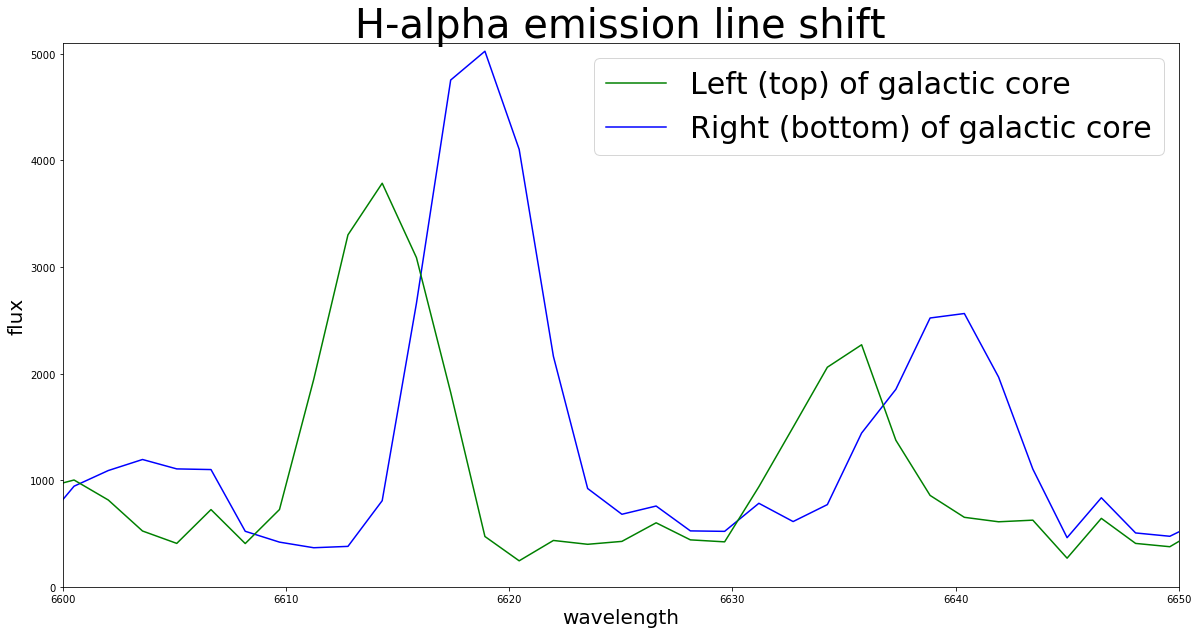

In [215]:
plt.figure(figsize=(20,10))
yb = C22_1_bottom['flux']
xb = C22_1_bottom['wl']
yt = C22_1_top['flux']
xt = C22_1_top['wl']
bottom, = plt.plot(xb,yb, color='b',label='Right (bottom) of galactic core')
top, = plt.plot(xt,yt, color='g',label='Left (top) of galactic core')
plt.xlim(6600,6650)
plt.ylim(0,5100)
plt.title("H-alpha emission line shift",fontsize=40)
plt.legend(handles=[top, bottom],fontsize=30)
plt.xlabel('wavelength',fontsize=20)
plt.ylabel('flux',fontsize=20)

In [216]:
#since H-alpha is peak in both data sets...gonna cheat a bit and just 
#search for peak of each data set to use to roughly calculate shift amount

#top
top_peak_flux = np.max(C22_1_top['flux']) #3786.2872589709518
a = np.where(C22_1_top['flux'] >= 3000) #b/c might wanna average
C22_1_top_peak = C22_1_top[a]
C22_1_top_peak

#bottom
bottom_peak_flux = np.max(C22_1_bottom['flux']) #5024.5795794428986
b = np.where(C22_1_bottom['flux'] >= 3000) #b/c might wanna average
C22_1_bottom_peak = C22_1_bottom[b]

print('this is top peaks:',C22_1_top_peak),
print('this is bottom peaks:',C22_1_bottom_peak) #forgot how to start new line


this is top peaks:      flux           wl      row no.
------------- ------------- -------
3301.85315059 6612.78036907    4224
3786.28725897 6614.31445021    4225
3088.47007374 6615.84854863    4226
this is bottom peaks:      flux           wl      row no.
------------- ------------- -------
  4754.375644 6617.38266429    4227
5024.57957944 6618.91679721    4228
4104.18827212 6620.45094735    4229


In [217]:
wl_top_C22_1 = np.mean(C22_1_top_peak['wl'])
wl_bottom_C22_1 = np.mean(C22_1_bottom_peak['wl'])

wl_top_C22_1 #6614.3144559679376
wl_bottom_C22_1 #6618.9168029520415
wl_difference_C22_1 = wl_bottom_C22_1 - wl_top_C22_1
wl_difference_C22_1 #wait...what do i need this for? meh dont

4.6023469841038604

## Calculating velocities

In [218]:
#getting LOS velocity for top & bottom

#line of sight velocity = c((observed-rest)/rest)
c = 300000 #km/s speed of light
top_obs_wl = wl_top_C22_1
bottom_obs_wl = wl_bottom_C22_1
rest_wl_halpha = 6563 #angstroms (1 A = 10^-9m) wait units cancel anyways...

C22_1_top_vlos = c * ((top_obs_wl - rest_wl_halpha) / rest_wl_halpha)
C22_1_bottom_vlos = c * ((bottom_obs_wl - rest_wl_halpha) / rest_wl_halpha)


print('top:',C22_1_top_vlos, 'bottom:',C22_1_bottom_vlos)

top: 2345.62498711 bottom: 2556.00196337


In [219]:
#getting rotational velocity

#assuming that recessional velocity can be top in this case, rather than 
#whole satellites recessional velocity b/c its very close, no (significant)
#redshift and why else do we have both from spectra? there seems to be enough
#data to detect this shift vs one emission line(no shift) - 
#can correct later if this is wrong assumption

#v_rotation = (v_los - v_rec)/sin(i) #i is inclination angle
#guessing i based on photometry 

i = 80 #degrees #complete guess based on photometry
v_rot = (C22_1_bottom_vlos - C22_1_top_vlos)/ np.sin(np.deg2rad(i))
print('satellite rotation is:',v_rot,'km/s')
#-15 km/s

satellite rotation is: 213.622380228 km/s


In [220]:
#same as above but w/o assumption on recessional velocity

#instead trying to determine C22-1's recessional v as a whole
#velocity = hubble constant x distance
hubble = 70 #(km/s)/Mpc #rough approx
distance = 37 #Mpc #approx distance to host galaxy
v_rec_host = hubble * distance
v_rec_host
i = 80 #degrees #complete guess based on photometry
v_rot = (C22_1_bottom_vlos - v_rec_host)/ np.sin(np.deg2rad(i))
print('satellite rotation is:',v_rot,'km/s', 
      'i dont like this value; too slow & -??')

satellite rotation is: -34.5225111436 km/s i dont like this value; too slow & -??


In [221]:
# same as above but trying diff los velocity
v_rot = (C22_1_top_vlos - v_rec_host)/ np.sin(np.deg2rad(i))
print('satellite rotation is:',v_rot,'km/s', 
      'i dont like this either; still -??')

satellite rotation is: -248.144891372 km/s i dont like this either; still -??


In [222]:
#same as above but trying another los velocity
#wl_difference_C22_1 #this is def not the los replacement
i=80
peak_from_original_C22_1 = 6617.38266429
v_rot = (peak_from_original_C22_1 - v_rec_host)/ np.sin(np.deg2rad(i))
print('satellite rotation is:',v_rot,'km/s', 
      'i dont like this either; super fast')

satellite rotation is: 4089.51153357 km/s i dont like this either; super fast


# Stopping here b/c obviously need more guidence, got diff rotation values...and way too many estimates

In [223]:
#thinking ahead, do we need a bolometric flux to get baryonic matter content?
#how to get baryonic matter from just visible/ir??...dust,BDs,BHs-not bright


In [11]:
#calculating mass using rotational velocity

#use photometry for radius? but dm halos bigger...hmmmm
#so maybe this eqt is for baryonic mass? 
#b/c dm gets scarce the further in toward galaxy core

# total mass = (rot_velocity^2 x radius)Gravitational const.
#total mass = dark matter + baryons

def total_mass(v,r):
    G = 4.301 * 10**(-9) #km^2 Mpc s^-2 M_solar^-1
    #scipy constants dont have astro units for G
    mass = (r * v**2) / G
    print ('this is the mass in solar masses:')
    return(mass)